In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# PyTorch Imports for Fashion Intelligence (GAN)
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Visualization Settings
%matplotlib inline
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print(f"✅ Setup Complete. Torch Version: {torch.__version__}")

✅ Setup Complete. Torch Version: 2.5.1


In [7]:
# 1. Pricing Data
pricing_df = pd.read_csv('../artifacts/pricing_train.csv')

# 2. Review Data
reviews_df = pd.read_csv('../artifacts/reviews_raw.csv')

# 3. Fashion Data (using Torchvision)
fashion_transform = transforms.Compose([transforms.ToTensor()])
fashion_data = datasets.FashionMNIST(
    root='../artifacts/fashion_data', 
    train=True, 
    download=False, 
    transform=fashion_transform
)

print(f"📊 Datasets Loaded: Pricing({len(pricing_df)}), Reviews({len(reviews_df)}), Fashion({len(fashion_data)})")

📊 Datasets Loaded: Pricing(1168), Reviews(5000), Fashion(60000)


In [6]:
# 1. Pricing Data (Regression)
pricing_df = pd.read_csv('../artifacts/pricing_train.csv')

# 2. Review Data (LLM/NLP)
reviews_df = pd.read_csv('../artifacts/reviews_raw.csv')

# 3. Fashion Data (GAN)
# We load this using torchvision as it's the standard for image pipelines
fashion_transform = transforms.Compose([transforms.ToTensor()])
fashion_data = datasets.FashionMNIST(
    root='../artifacts/fashion_data', 
    train=True, 
    download=False, 
    transform=fashion_transform
)
fashion_loader = DataLoader(fashion_data, batch_size=25, shuffle=True)

print("✅ All datasets loaded successfully!")

✅ All datasets loaded successfully!


In [9]:
pricing_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,255,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,145000
1,1067,60,RL,59.0,7837,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2009,WD,Normal,178000
2,639,30,RL,67.0,8777,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,5,2008,WD,Normal,85000
3,800,50,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2007,WD,Normal,175000
4,381,50,RL,50.0,5000,Pave,Pave,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,127000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,1096,20,RL,78.0,9317,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Normal,176432
1164,1131,50,RL,65.0,7804,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,12,2009,WD,Normal,135000
1165,1295,20,RL,60.0,8172,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,115000
1166,861,50,RL,55.0,7642,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,6,2007,WD,Normal,189950


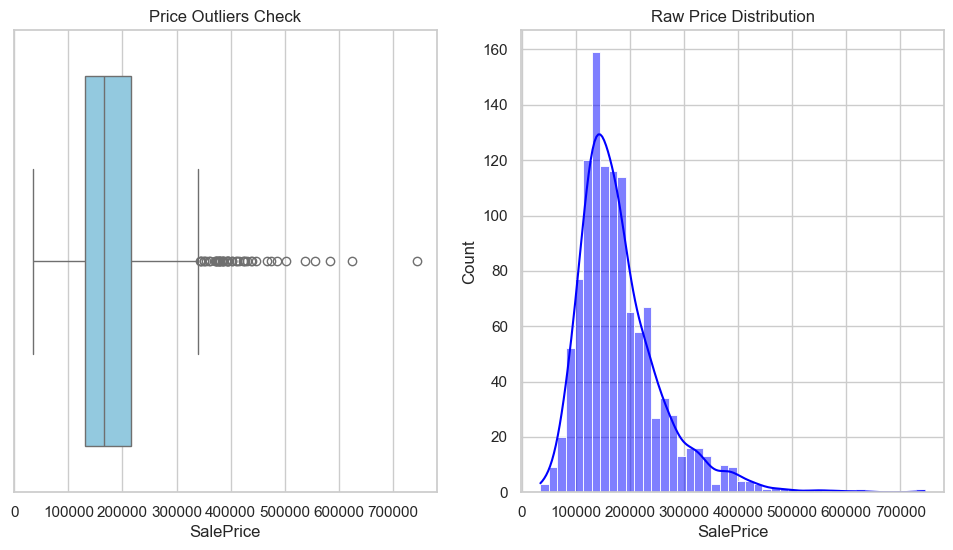

KeyError: 'price'

In [11]:
# Check for Outliers
plt.subplot(1, 2, 1)
sns.boxplot(x=pricing_df['SalePrice'], color='skyblue')
plt.title('Price Outliers Check')

# Check for Skewness
plt.subplot(1, 2, 2)
sns.histplot(pricing_df['SalePrice'], kde=True, color='blue')
plt.title('Raw Price Distribution')
plt.show()

# Accuracy Tip: If the distribution is a "tail," suggest Log Transformation
print(f"Skewness Score: {pricing_df['price'].skew():.2f}")

In [12]:
# 1. Detailed Summary Statistics
stats = pricing_df['SalePrice'].describe()
skewness = pricing_df['SalePrice'].skew()
kurtosis = pricing_df['SalePrice'].kurt()

print(f"--- Pricing Statistics ---")
print(stats)
print(f"Skewness: {skewness:.2f} (High skew > 1 requires Log Transform)")
print(f"Kurtosis: {kurtosis:.2f} (High kurtosis indicates heavy outliers)")

# 2. Interquartile Range (IQR) for Outlier Detection
Q1 = pricing_df['SalePrice'].quantile(0.25)
Q3 = pricing_df['SalePrice'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = pricing_df[(pricing_df['SalePrice'] < lower_bound) | (pricing_df['SalePrice'] > upper_bound)]
print(f"Number of statistical outliers: {len(outliers)}")

--- Pricing Statistics ---
count      1168.000000
mean     181441.541952
std       77263.583862
min       34900.000000
25%      130000.000000
50%      165000.000000
75%      214925.000000
max      745000.000000
Name: SalePrice, dtype: float64
Skewness: 1.74 (High skew > 1 requires Log Transform)
Kurtosis: 5.48 (High kurtosis indicates heavy outliers)
Number of statistical outliers: 48


In [13]:
# 1. Calculate Dataset-Wide Mean and Std (Required for Normalization)
# We use a loader to iterate through the 60,000 images
loader = DataLoader(fashion_data, batch_size=1000, shuffle=False)
imgs, _ = next(iter(loader))

mean = imgs.mean()
std = imgs.std()

print(f"--- Fashion Image Stats ---")
print(f"Dataset Mean: {mean.item():.4f}")
print(f"Dataset Std Dev: {std.item():.4f}")

# 2. Class Balance Check
from collections import Counter
labels_map = Counter(fashion_data.targets.numpy())
print(f"Class Distribution: {labels_map}") 
# Note: Fashion-MNIST is perfectly balanced (6000 per class), which is ideal for GANs.

--- Fashion Image Stats ---
Dataset Mean: 0.2829
Dataset Std Dev: 0.3531
Class Distribution: Counter({np.int64(9): 6000, np.int64(0): 6000, np.int64(3): 6000, np.int64(2): 6000, np.int64(7): 6000, np.int64(5): 6000, np.int64(1): 6000, np.int64(6): 6000, np.int64(4): 6000, np.int64(8): 6000})


In [14]:
# 1. Sentiment Class Balance (Frequency % )
class_freq = reviews_df['stars'].value_counts(normalize=True) * 100
print("--- Review Sentiment Distribution ---")
print(class_freq)

# 2. Text Length Statistics (Word Counts)
reviews_df['word_count'] = reviews_df['review_body'].fillna("").apply(lambda x: len(x.split()))
print("\n--- Review Length Stats ---")
print(reviews_df['word_count'].describe())

# 3. Identifying Sparsity
empty_reviews = reviews_df['review_body'].isna().sum()
print(f"Missing Review Texts: {empty_reviews}")

--- Review Sentiment Distribution ---
stars
5    57.28
4    20.00
3    10.00
1     7.20
2     5.52
Name: proportion, dtype: float64

--- Review Length Stats ---
count    5000.000000
mean       71.428600
std        88.217083
min         0.000000
25%        17.000000
50%        45.000000
75%        92.000000
max      1511.000000
Name: word_count, dtype: float64
Missing Review Texts: 0
